In [1]:
import numpy as np
import pandas as pd

class DataPreprocessor:

    def __init__(self):
        pass

    def CustomSmoother(self, x, alpha):
        s0 = x[0]
        smoothed_statistic = [s0]
        n = len(x)
        for i in range(1, n):
            s1 = alpha * x[i] + (1 - alpha) * s0
            smoothed_statistic.append(s1)
            s0 = s1
        smoothed_statistic = np.array(smoothed_statistic)
        return smoothed_statistic

    def PandaSmoother(self, x):
        return pd.Series(x).ewm(span=20).mean()

In [2]:
#This module defines function for calculating technical indicators from the stock data
#Author: Luckyson Khaidem
#Date: 21/1/16

import numpy as np

#exponential weighted moving average
def ema(x,p):

        x = x.squeeze()
        prev_ema = x[:p].mean()
        ema = [prev_ema]
        m = len(x)
        multiplier = 2/float(p+1)
        for i in range(p,m):
                cur_ema = (x[i] - prev_ema)*multiplier + prev_ema
                prev_ema = cur_ema
                ema.append(cur_ema)
        return np.array(ema)

#Relative Strength Index
def getRSI(x):
    x = x.squeeze()
    n = len(x)
    x0 = x[:n-1]
    x1 = x[1:]
    change = x1 - x0
    avgGain = []
    avgLoss = []
    loss = 0
    gain = 0
    for i in range(14):
        if change[i] > 0 :
            gain += change[i]
        elif change[i] < 0:
            loss += abs(change[i])
    averageGain = gain/14.0
    averageLoss = loss/14.0
    avgGain.append(averageGain)
    avgLoss.append(averageLoss)
    for i in range(14,n-1):
        if change[i] >= 0:
            avgGain.append((avgGain[-1]*13+change[i])/14.0)
            avgLoss.append((avgLoss[-1]*13)/14.0)
        else:
            avgGain.append((avgGain[-1]*13)/14.0)
            avgLoss.append((avgLoss[-1]*13+abs(change[i]))/14.0)
    avgGain = np.array(avgGain)
    avgLoss = np.array(avgLoss)
    RS = avgGain/avgLoss
    RSI = 100 -(100/(1+RS))

    return np.c_[RSI,x1[13:]]

def getStochasticOscillator(x):

    high = x[:,1].squeeze()
    low = x[:,2].squeeze()
    close = x[:,3].squeeze()
    n = len(high)
    highestHigh = []
    lowestLow = []
    for i in range(n-13):
        highestHigh.append(high[i:i+14].max())
        lowestLow.append(low[i:i+14].min())
    highestHigh = np.array(highestHigh)
    lowestLow = np.array(lowestLow)
    k = 100*((close[13:]-lowestLow)/(highestHigh-lowestLow))

    return np.c_[k,close[13:]]

def getWilliams(x):

    high = x[:,1].squeeze()
    low = x[:,2].squeeze()
    close = x[:,3].squeeze()
    n = len(high)
    highestHigh = []
    lowestLow = []
    for i in range(n-13):
        highestHigh.append(high[i:i+14].max())
        lowestLow.append(low[i:i+14].min())
    highestHigh = np.array(highestHigh)
    lowestLow = np.array(lowestLow)
    w = -100*((highestHigh-close[13:])/(highestHigh-lowestLow))

    return np.c_[w,close[13:]]

def getMACD(close):

        ma1 = ema(close.squeeze(),12)
        ma2 = ema(close.squeeze(),26)
        macd =  ma1[14:] - ma2

        return np.c_[macd,close[len(close) - len(macd):]]

def getPriceRateOfChange(close,n_days):

        close = close.squeeze()
        n = len(close)
        x0 = close[:n-n_days]
        x1 = close[n_days:]
        PriceRateOfChange = (x1 - x0)/x0

        return np.c_[PriceRateOfChange,x1]

def getOnBalanceVolume(X):

        close = X[:,3].squeeze()
        volume = X[:,4].squeeze()[1:]
        n = len(close)
        x0 = close[:n-1]
        x1 = close[1:]
        change = x1 - x0
        OBV = []
        prev_OBV = 0

        for i in range(n-1):
                if change[i] > 0:
                        current_OBV = prev_OBV + volume[i]
                elif change[i] < 0:
                        current_OBV = prev_OBV - volume[i]
                else:
                        current_OBV = prev_OBV
                OBV.append(current_OBV)
                prev_OBV = current_OBV
        OBV = np.array(OBV)

        return np.c_[OBV,x1]


In [3]:
import os
import numpy as np
from sklearn.metrics import roc_curve,auc, confusion_matrix
from matplotlib import pyplot as plt
from matplotlib import animation
from sklearn.ensemble import RandomForestClassifier

class Evaluator:

	def __init__(self,xtest,ytest,y_pred,LearningModel):
		self.xtest = xtest
		self.ytest = ytest
		self.y_pred = y_pred
		self.model = LearningModel

	def confusionMatrix(self):

		self.confusion_matrix = confusion_matrix(self.ytest, self.y_pred)

	def getPerformanceMetrics(self):

		self.confusionMatrix()
# TN + TP / TP+TN+FP+FN
		accuracy = (
					float((self.confusion_matrix[0][0]+self.confusion_matrix[1][1]))/
					(self.confusion_matrix[0][0]+self.confusion_matrix[0][1]+self.confusion_matrix[1][0]+self.confusion_matrix[1][1])
			)
		precision = (#TP/TP+FP
					float((self.confusion_matrix[1][1]))/
					(self.confusion_matrix[1][1] + self.confusion_matrix[0][1])
			)
		recall = (#TP/TP+FN
				float((self.confusion_matrix[1][1]))/
				(self.confusion_matrix[1][1]+self.confusion_matrix[1][0])
			)
		specificity = (#TN/TN+FP
				float((self.confusion_matrix[0][0]))/
				(self.confusion_matrix[0][0] + self.confusion_matrix[0][1])
			)

		return accuracy, recall, precision, specificity

	def drawROC(self):

		base_dir = os.path.dirname
		abspath = os.path.abspath
		#dir_name =  base_dir(base_dir(base_dir(abspath(__file__))))

		y_prob = self.model.predict_proba(self.xtest)

		true_probability_estimate = y_prob[:,1]

		fpr,tpr,threshold = roc_curve(self.ytest,true_probability_estimate)
		area = auc(fpr,tpr)
		plt.figure()
		plt.plot(fpr,tpr,linewidth = 2.0,label = "ROC curve (Area= %0.2f)" % area)
		plt.plot([0,1],[0,1],"r--")
		plt.xlabel("False Postive Rate")
		plt.ylabel("True Positive Rate")
		plt.legend(loc = "lower right")
		plt.show(block = False)

		#plt.savefig(savepath)
		#plt.close()

	def oob_vs_n_trees(self,max_trees,Xtrain, ytrain):

		# First set up the figure, the axis, and the plot element we want to animate
		print ("")
		print ("Number of Trees\t\tOOB Error Rate")
		fig = plt.figure()
		ax = plt.axes(xlim=(0, max_trees), ylim=(0,1))
		plt.xlabel("Number of trees")
		plt.ylabel("OOB error")
		line, = ax.plot([], [], lw=2, color='red')

		# initialization function: plot the background of each frame
		def init():
		    line.set_data([], [])
		    return line,

		number_of_trees = range(2,max_trees + 1)
		oob_errors = []
		# animation function.  This is called sequentially
		def animate(i):

			model = RandomForestClassifier(warm_start = True, oob_score = True, n_estimators = i)
			model.fit(Xtrain,ytrain)
			oob_error = 1 - model.oob_score_
			oob_errors.append(oob_error)
			plt.plot(i,oob_error,linewidth = 2.0)
			print ("{}\t\t\t{}".format(i,oob_error))

			line.set_data(number_of_trees[:len(oob_errors)], oob_errors)
			return line,

		# call the animator.  blit=True means only re-draw the parts that have changed.
		anim = animation.FuncAnimation(fig, animate, init_func=init, blit=True, frames=number_of_trees, interval=100, repeat = False)
		#anim.save('basic_animation', fps=30)
       
		for i in range(2,max_trees + 1):
			model = RandomForestClassifier(warm_start = True,
				oob_score = True,
				n_estimators = i)
			model.fit(Xtrain,ytrain)
			oob_error = 1 - model.oob_score_
			oob_errors.append(oob_error)
			print (i,oob_error)







	def plotClassificationResult(self):
		self.confusionMatrix()
		x = [i + 3.0 for i in range(4)]  #Distance
		xlabel = ["TP","FN","FP","TN"]
		plt.figure()
		plt.grid(True)
		plt.bar(x,self.confusion_matrix.reshape(-1), color= np.random.random((4,3)))
		plt.xticks([i + 3.0 for i in range(4)],xlabel)
		plt.show(block = False)






C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Enter the stock_symbol (AAPL,samsung, AMS, AMZN, FB, MSFT, NKE, SNE, TATA, TWTR, TYO): aapl
Enter the trading window: 30
{1.0, -1.0}
Cross Validation scores
Validation Set 0 score: 0.7542310522442973
Validation Set 1 score: 0.7503681885125184
Validation Set 2 score: 0.7621502209131075
Validation Set 3 score: 0.759941089837997
Validation Set 4 score: 0.7503681885125184

Accuracy: 0.7729681978798587
Recall: 0.8478260869565217
Precision: 0.774468085106383
Specificity: 0.6741803278688525


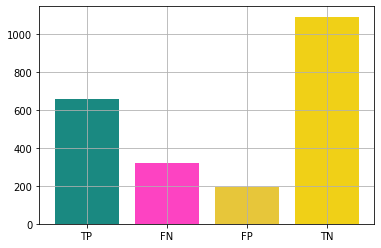

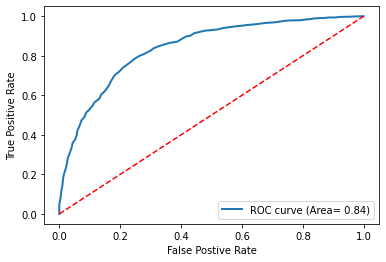

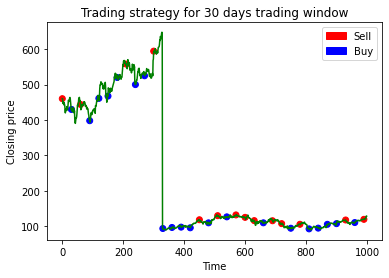

Press y to generate OOB vs Number of estimators graph:y

Number of Trees		OOB Error Rate
2 0.4411721395965248
3 0.3950817258135768
4 0.38919157708732144


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


5 0.36415844500073624
6 0.3450154616404064


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


7 0.332940656751583
8 0.34000883522308933


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


9 0.3163009865999117
10 0.30525695773818284


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


11 0.30599322632896475
12 0.2886172875865115


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


13 0.2839051686055073


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


14 0.29627448093064346
15 0.29642173464879984


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


16 0.2828743925784126


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


17 0.28125460167869243
18 0.2766897364158445
19 0.26741275217199234


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


20 0.2781622735974083


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


21 0.2763952289795317
22 0.2700633190988072
23 0.2687380356353998
24 0.2752171992342807
25 0.25195111176557206
26 0.26829627448093063
27 0.2652039463996466
28 0.2594610513915476
29 0.2603445737004859
30 0.2491532911206008
31 0.2547489324105434
32 0.2501840671476955
33 0.24620821675747318
34 0.2590192902370785
35 0.2582830216462966
36 0.24488293329406563
37 0.2506258283021646
38 0.2426741275217199
39 0.25033132086585186
40 0.24473567957590925
41 0.25047857458400824
42 0.24532469444853477
43 0.24576645560300403
44 0.23840376969518484
45 0.2363422176409954
46 0.24149609777646885
47 0.241937858930938
48 0.238845530849654
49 0.2451774407303784
50 0.24237962008540714
51 0.24223236636725076
52 0.24399941098512734
53 0.2442939184214401
54 0.23648947135915177
55 0.23324988955971138
56 0.23678397879546453
57 0.24458842585775287
58 0.23781475482255932
59 0.24164335149462524
60 0.23693123251362092
61 0.23575320276836986
62 0.2412015903401561
63 0.23486968045943157
64 0.23840376969518484
65 0.23398

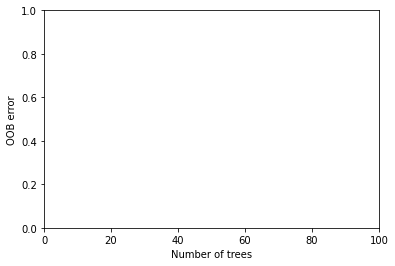

In [4]:
from pandas import read_csv
import numpy as np
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.model_selection import train_test_split
#from TechnicalAnalysis import *
# from DataFetcher import DataFetcher
import os
from datetime import datetime
#from matplotlib import pyplot as plt
#from DataPreprocessor import DataPreprocessor
#from ModelEvaluation import Evaluator
from multiprocessing import Process
import matplotlib.patches as mpatches
import pandas as pd
from sklearn.model_selection import cross_val_score

def xrange(y):
  return range(y)
def getData(CSVFile):

	smoother = DataPreprocessor()
	data = read_csv(CSVFile)
	data = data[::-1] # reverse
	ohclv_data = np.c_[data['Open'],
					   data['High'],
					   data['Low'],
					   data['Close'],
					   data['Volume']]

	#smoothened_ohclv_data = DataPreprocessor.PandaSmoother(ohclv_data,ohclv_data)
	return  ohclv_data, np.array(data["Close"]), list(data["Date"])

def getTechnicalIndicators(X,d):

	RSI = getRSI(X[:,3])
	StochasticOscillator = getStochasticOscillator(X)
	Williams = getWilliams(X)


	MACD = getMACD(X[:,3])
	PROC = getPriceRateOfChange(X[:,3],d)
	OBV = getOnBalanceVolume(X)

	min_len = min(len(RSI),
				  len(StochasticOscillator),
				  len(Williams),
				  len(MACD),
				  len(PROC),
				  len(OBV))

	RSI = RSI[len(RSI) - min_len:]
	StochasticOscillator = StochasticOscillator[len(StochasticOscillator) - min_len:]
	Williams = Williams[len(Williams) - min_len: ]
	MACD = MACD[len(MACD) - min_len:]
	PROC = PROC[len(PROC) - min_len:]
	OBV = OBV[len(OBV) - min_len:]


	feature_matrix = np.c_[RSI[:,0],
						   StochasticOscillator[:,0],
						   Williams[:,0],
						   MACD[:,0],
						   PROC[:,0],
						   OBV[:,0]]

	return feature_matrix

def prepareData(X,close,date,d):

	feature_matrix = getTechnicalIndicators(X,d)

	number_of_samples = feature_matrix.shape[0]
	date = date[len(date) - number_of_samples:]
	close = close[len(close) - number_of_samples:]

	#y0 = feature_matrix[:,-1][ :number_of_samples-d]
	#y1 = feature_matrix[:,-1][d:]

	y0 = close[:number_of_samples - d]
	y1 = close[d:]

	feature_matrix_1 = feature_matrix[:number_of_samples-d]
	feature_matrix_2 = feature_matrix[number_of_samples - 1000:]
	date = date[number_of_samples - 1000:]



	#closeplot = feature_matrix[:,-1][number_of_samples - 1000:]
	closeplot = close[number_of_samples - 1000:]
	y = np.sign(y1 - y0)

	feature_matrix_1 = feature_matrix_1[:, range(6)]

	return feature_matrix_1,y,feature_matrix_2[:,range(6)],closeplot,date



def plotTradingStrategy(model, xplot, closeplot, Trading_Day,date):

    colorMap = {-1.0:"r",1.0:"b",0.0:"y"}
    tradeMap = {-1.0:"Sell",1.0:"Buy",0.0:"Buy"}
    plt.figure()
    plt.plot(closeplot, c = "g")
    x = [xplot[i] for i in range(0,len(xplot),Trading_Day)]
    y = [closeplot[i] for i in range(0, len(closeplot),Trading_Day)]
    y_pred = model.predict(x)

    c = [colorMap[y_pred[i]] for i in range(len(y_pred))]

    df = pd.DataFrame(np.c_[[ i+1 for i in range(0, len(xplot),Trading_Day)], x, y, [tradeMap[y_pred[i]] for i in xrange(len(y_pred)) ]],
   			columns = ["Day","RSI","Stochastic Oscillator","Williams","MACD","Price Rate Of Change","On Balance Volume","Close","Buy/Sell"])
    df.to_csv("AAPLBuySellTradePoints.csv",index = False)


    plt.scatter([i for i in range(0,len(xplot),Trading_Day)],y, c = c)
	#plt.xticks([i for i in xrange(0,len(xplot),Trading_Day)],[date[i] for i in xrange(0,len(xplot),Trading_Day)])
    red_patch = mpatches.Patch(color='red', label='Sell')
    blue_patch = mpatches.Patch(color = "blue", label = "Buy")
    plt.legend(handles = [red_patch,blue_patch])
    plt.xlabel("Time")
    plt.ylabel("Closing price")
    plt.title("Trading strategy for {} days trading window".format(Trading_Day))
    plt.savefig("TradingStrategy.png")
    plt.show(block = False)


def main(stock_symbol,Trading_Day):

  #fetcher = DataFetcher()

  #fetch_result = fetcher.getHistoricalData(stock_symbol)
  #if fetch_result == -1:
  #    raise Exception("NO INTERNET CONNECTIVITY OR INVALID STOCK SYMBOL")

  #dir_name = os.path.dirname(os.path.abspath(__file__))
  #filename = stock_symbol+".csv"
  #CSVFile = os.path.join(dir_name,"Dataset",filename)

  filename = stock_symbol+".csv"
  CSVFile = os.path.join("C:/Users/User/Downloads/StockMarketPedicition-master/StockMarketPedicition-master/Dataset/",filename)

  ohclv_data, close, date= getData(CSVFile)

	#current_data = regression(ohclv_data)
	#ohclv_data.append(current_data)

  ohclv_data = np.array(ohclv_data)

  X,y,xplot,closeplot,dateplot = prepareData(ohclv_data, close, date, Trading_Day)
  y[y == 0] = 1

  Xtrain,Xtest,ytrain,ytest = train_test_split(X,y, random_state = 0)

  model = RandomForestClassifier(n_estimators = 100,criterion = "gini", random_state = 0)

  scores = cross_val_score(model, Xtrain, ytrain, cv = 5)
  print (set(ytrain))
  print ("Cross Validation scores")
  for i, score in enumerate(scores):
      print ("Validation Set {} score: {}".format(i, score))
  model.fit(Xtrain, ytrain)
  y_pred = model.predict(Xtest)
  Eval = Evaluator(Xtest,ytest,y_pred,model)

  accuracy, recall, precision, specificity = Eval.getPerformanceMetrics()

  print ("")
  print ("Accuracy:",accuracy)
  print ("Recall:",recall)
  print ("Precision:",precision)
  print ("Specificity:",specificity)

  Eval.plotClassificationResult()
  Eval.drawROC()
  plotTradingStrategy(model,xplot,closeplot,Trading_Day,dateplot)
  c = input("Press y to generate OOB vs Number of estimators graph:")
  if c == "y" or c == "Y":
      Eval.oob_vs_n_trees(100,Xtrain,ytrain)




	# raw_input("Press enter to genereate OOB vs Number of estimators graph:")
	# p.start()
	# print "LOL"
	# p.join()



stock_symbol = input("Enter the stock_symbol (AAPL,samsung, AMS, AMZN, FB, MSFT, NKE, SNE, TATA, TWTR, TYO): ")
Trading_Day = int(input("Enter the trading window: "))
main(stock_symbol.upper(),Trading_Day)









Enter the stock_symbol (AAPL,samsung, AMS, AMZN, FB, MSFT, NKE, SNE, TATA, TWTR, TYO): aapl
Enter the trading window: 60
{1.0, -1.0}
Cross Validation scores
Validation Set 0 score: 0.8237037037037037
Validation Set 1 score: 0.832468495181616
Validation Set 2 score: 0.8443291326908822
Validation Set 3 score: 0.8272794662713121
Validation Set 4 score: 0.8228317272053373

Accuracy: 0.840818141396176
Recall: 0.9105058365758755
Precision: 0.8280254777070064
Specificity: 0.7479253112033195


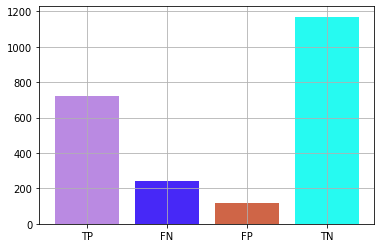

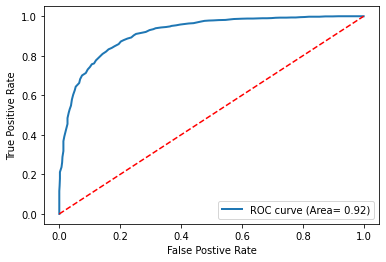

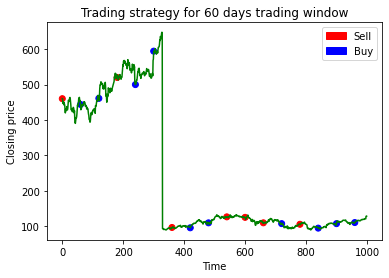

Press y to generate OOB vs Number of estimators graph:0


In [10]:

stock_symbol = input("Enter the stock_symbol (AAPL,samsung, AMS, AMZN, FB, MSFT, NKE, SNE, TATA, TWTR, TYO): ")
Trading_Day = int(input("Enter the trading window: "))
main(stock_symbol.upper(),Trading_Day)

Enter the stock_symbol (AAPL,samsung, AMS, AMZN, FB, MSFT, NKE, SNE, TATA, TWTR, TYO): aapl
Enter the trading window: 90
{1.0, -1.0}
Cross Validation scores
Validation Set 0 score: 0.883668903803132
Validation Set 1 score: 0.8701492537313433
Validation Set 2 score: 0.8537313432835821
Validation Set 3 score: 0.8820895522388059
Validation Set 4 score: 0.8604477611940299

Accuracy: 0.8863025962399284
Recall: 0.9261194029850747
Precision: 0.8889684813753582
Specificity: 0.8266219239373602


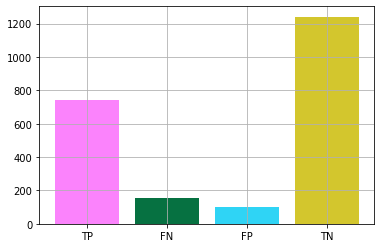

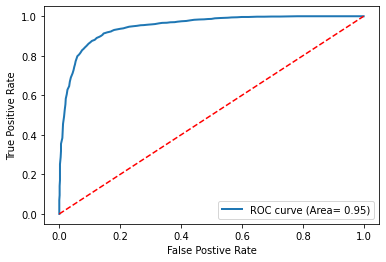

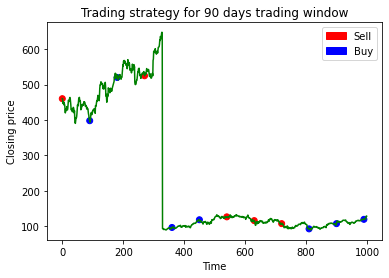

Press y to generate OOB vs Number of estimators graph:0


In [11]:

stock_symbol = input("Enter the stock_symbol (AAPL,samsung, AMS, AMZN, FB, MSFT, NKE, SNE, TATA, TWTR, TYO): ")
Trading_Day = int(input("Enter the trading window: "))
main(stock_symbol.upper(),Trading_Day)

Enter the stock_symbol (AAPL,samsung, AMS, AMZN, FB, MSFT, NKE, SNE, TATA, TWTR, TYO): samsung
Enter the trading window: 30
{1.0, -1.0}
Cross Validation scores
Validation Set 0 score: 0.715625
Validation Set 1 score: 0.6984375
Validation Set 2 score: 0.6964006259780907
Validation Set 3 score: 0.6713615023474179
Validation Set 4 score: 0.6682316118935837

Accuracy: 0.7110694183864915
Recall: 0.6625258799171843
Precision: 0.6881720430107527
Specificity: 0.7512864493996569


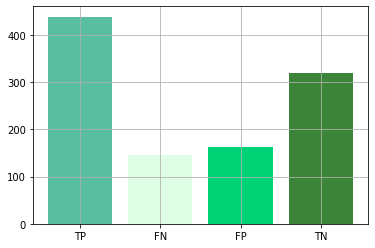

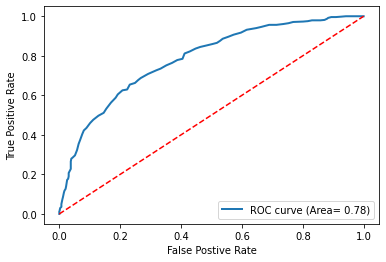

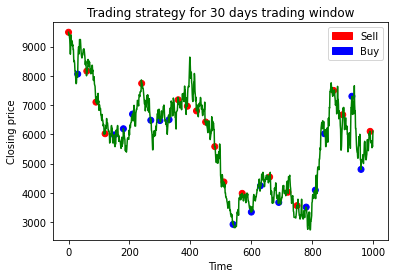

Press y to generate OOB vs Number of estimators graph:0


In [12]:

stock_symbol = input("Enter the stock_symbol (AAPL,samsung, AMS, AMZN, FB, MSFT, NKE, SNE, TATA, TWTR, TYO): ")
Trading_Day = int(input("Enter the trading window: "))
main(stock_symbol.upper(),Trading_Day)

Enter the stock_symbol (AAPL,samsung, AMS, AMZN, FB, MSFT, NKE, SNE, TATA, TWTR, TYO): samsung
Enter the trading window: 60
{1.0, -1.0}
Cross Validation scores
Validation Set 0 score: 0.7733755942947702
Validation Set 1 score: 0.7654516640253566
Validation Set 2 score: 0.7380952380952381
Validation Set 3 score: 0.7365079365079366
Validation Set 4 score: 0.765079365079365

Accuracy: 0.768791627021884
Recall: 0.6479166666666667
Precision: 0.8077922077922078
Specificity: 0.8704028021015762


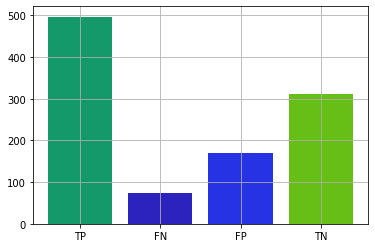

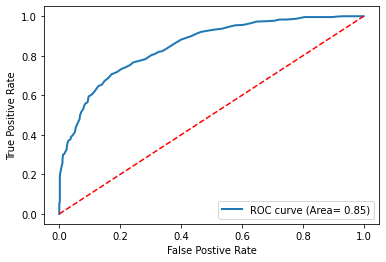

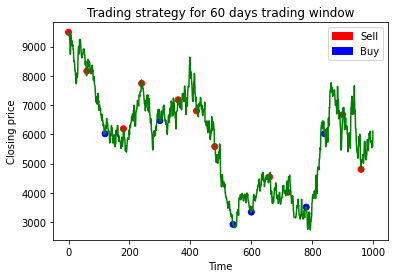

Press y to generate OOB vs Number of estimators graph:0


In [13]:

stock_symbol = input("Enter the stock_symbol (AAPL,samsung, AMS, AMZN, FB, MSFT, NKE, SNE, TATA, TWTR, TYO): ")
Trading_Day = int(input("Enter the trading window: "))
main(stock_symbol.upper(),Trading_Day)

Enter the stock_symbol (AAPL,samsung, AMS, AMZN, FB, MSFT, NKE, SNE, TATA, TWTR, TYO): samsung
Enter the trading window: 90
{1.0, -1.0}
Cross Validation scores
Validation Set 0 score: 0.7958199356913184
Validation Set 1 score: 0.819935691318328
Validation Set 2 score: 0.7777777777777778
Validation Set 3 score: 0.785829307568438
Validation Set 4 score: 0.7520128824476651

Accuracy: 0.806949806949807
Recall: 0.7494145199063232
Precision: 0.774818401937046
Specificity: 0.8472906403940886


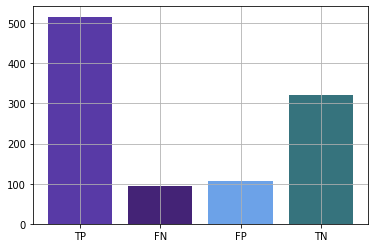

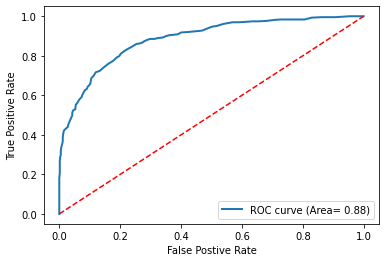

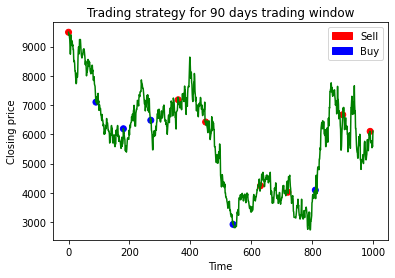

Press y to generate OOB vs Number of estimators graph:0


In [14]:

stock_symbol = input("Enter the stock_symbol (AAPL,samsung, AMS, AMZN, FB, MSFT, NKE, SNE, TATA, TWTR, TYO): ")
Trading_Day = int(input("Enter the trading window: "))
main(stock_symbol.upper(),Trading_Day)

Enter the stock_symbol (AAPL,samsung, AMS, AMZN, FB, MSFT, NKE, SNE, TATA, TWTR, TYO): ge
Enter the trading window: 30
{1.0, -1.0}
Cross Validation scores
Validation Set 0 score: 0.7259615384615384
Validation Set 1 score: 0.7388167388167388
Validation Set 2 score: 0.7157287157287158
Validation Set 3 score: 0.7239057239057239
Validation Set 4 score: 0.7306397306397306

Accuracy: 0.7446624350836699
Recall: 0.8069179143004647
Precision: 0.7536162005785921
Specificity: 0.6657946370176586


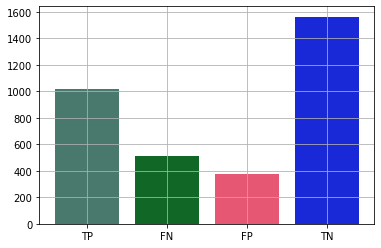

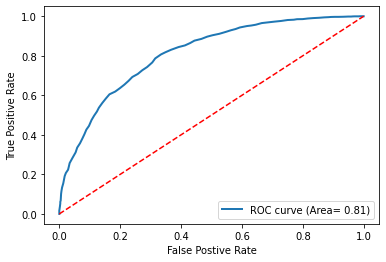

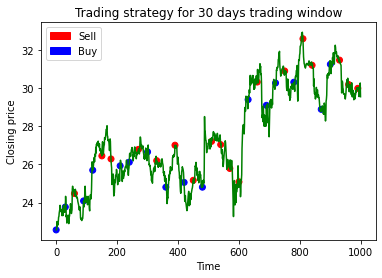

Press y to generate OOB vs Number of estimators graph:0


In [15]:

stock_symbol = input("Enter the stock_symbol (AAPL,samsung, AMS, AMZN, FB, MSFT, NKE, SNE, TATA, TWTR, TYO): ")
Trading_Day = int(input("Enter the trading window: "))
main(stock_symbol.upper(),Trading_Day)

Enter the stock_symbol (AAPL,samsung, AMS, AMZN, FB, MSFT, NKE, SNE, TATA, TWTR, TYO): ge
Enter the trading window: 60
{1.0, -1.0}
Cross Validation scores
Validation Set 0 score: 0.7909222597778851
Validation Set 1 score: 0.7898550724637681
Validation Set 2 score: 0.8120772946859903
Validation Set 3 score: 0.785024154589372
Validation Set 4 score: 0.785024154589372

Accuracy: 0.808171544479861
Recall: 0.8648379052369077
Precision: 0.816
Specificity: 0.7295988934993084


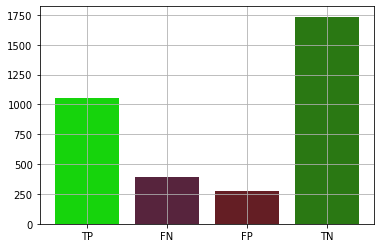

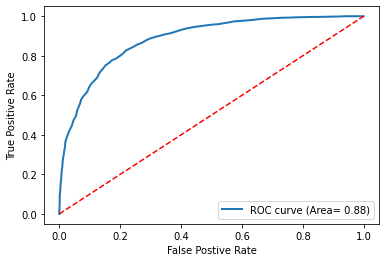

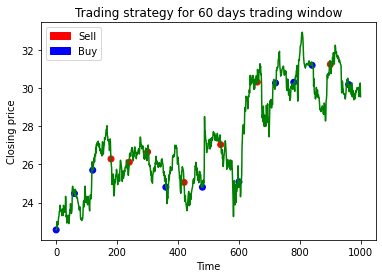

Press y to generate OOB vs Number of estimators graph:0


In [16]:
stock_symbol = input("Enter the stock_symbol (AAPL,samsung, AMS, AMZN, FB, MSFT, NKE, SNE, TATA, TWTR, TYO): ")
Trading_Day = int(input("Enter the trading window: "))
main(stock_symbol.upper(),Trading_Day)

Enter the stock_symbol (AAPL,samsung, AMS, AMZN, FB, MSFT, NKE, SNE, TATA, TWTR, TYO): ge
Enter the trading window: 90
{1.0, -1.0}
Cross Validation scores
Validation Set 0 score: 0.8419010669253152
Validation Set 1 score: 0.8161086851043183
Validation Set 2 score: 0.8262979136341582
Validation Set 3 score: 0.8403687530325085
Validation Set 4 score: 0.8403687530325085

Accuracy: 0.85011641443539
Recall: 0.915418076365394
Precision: 0.8478066248880931
Specificity: 0.7512801755669349


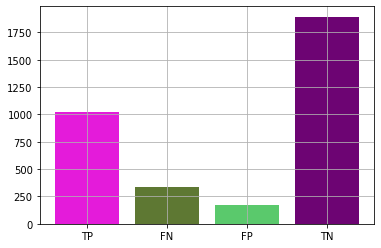

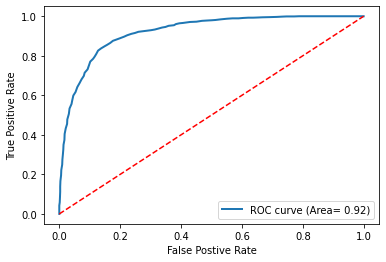

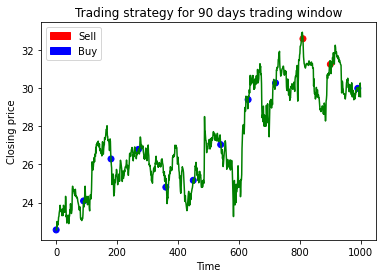

Press y to generate OOB vs Number of estimators graph:0


In [17]:
stock_symbol = input("Enter the stock_symbol (AAPL,samsung, AMS, AMZN, FB, MSFT, NKE, SNE, TATA, TWTR, TYO): ")
Trading_Day = int(input("Enter the trading window: "))
main(stock_symbol.upper(),Trading_Day)